In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Contents
1. 데이터 로드 및 전처리
2. 레이어 쌓기
3. 인코더 함수 구현
4. 디코더 함수 구현
5. 트랜스포머 함수 정의
6. 모델 생성 및 학습
7. 챗봇 테스트하기
8. 회고

# 1. 데이터 로드 및 전처리
데이터 출처 -> https://github.com/songys/Chatbot_data
### Data description

인공데이터입니다. 일부 이별과 관련된 질문에서 다음카페 "사랑보다 아름다운 실연( http://cafe116.daum.net/_c21_/home?grpid=1bld )"에서 자주 나오는 이야기들을 참고하여 제작하였습니다. 가령 "이별한 지 열흘(또는 100일) 되었어요"라는 질문에 챗봇이 위로한다는 취지로 답변을 작성하였습니다.

챗봇 트레이닝용 문답 페어 11,823개
일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

In [2]:
data_filepath = os.getenv('HOME')+ '/aiffel/transformer_chatbot/data/ChatbotData .csv'
df = pd.read_csv(data_filepath,usecols=['Q','A'])
df

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
dtypes: object(2)
memory usage: 184.9+ KB


Null 값 없는거 확인~!

### 1.1 데이터 추가
#### 1) 웰니스 대화 스크립트 데이터셋
- 정신건강 상담 주제의 359개 대화의도에 대한 5,232개의 사용자 발화 및 1,023개의 챗봇 발화 구축

In [4]:
# !pip install openpyxl

In [5]:
data_filepath2 = os.getenv('HOME')+ '/aiffel/transformer_chatbot/data/웰니스_대화_스크립트_데이터셋.xlsx'
df2 = pd.read_excel(data_filepath2,usecols=['유저','챗봇'])
df2.columns = ['Q','A']

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5231 entries, 0 to 5230
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       5231 non-null   object
 1   A       1034 non-null   object
dtypes: object(2)
memory usage: 81.9+ KB


**결측치 처리**

In [7]:
df2['A'].fillna(method='bfill',inplace=True)
df2.tail(20)

,Q,A
5211,"약만 좀 타서 먹었는데, 조금 나아지긴 했어.",상태가 더 안 좋아지셨군요. 걱정이 되네요.
5212,병원 안가고 그냥 지냈는데 자연스럽게 괜찮아졌어요.,상태가 더 안 좋아지셨군요. 걱정이 되네요.
5213,지금 상태가 너무 안 좋아서 학교 안 나가고 있어요.,상태가 더 안 좋아지셨군요. 걱정이 되네요.
5214,진짜 심해진 거 같긴 해요.,정말 힘드시겠어요. 지금도 증상이 심하신가요?
5215,그런데 증상이 나빠진 거 같아.,너무 심하시면 병원을 다시 가보는 건 어떨까요?
5216,처음엔 무시해보려고 했다? 그런데 점점 심해지고 있는 거 같아.,NaN
5217,그러니까 불안증이 다시 심해지는 게 느껴졌어.,NaN
5218,바로 증상이 악화되더라고요.,NaN
5219,일주일정도 됐는데 점점 심해지는 것 같아요.,NaN
5220,약을 끊었더니 증상이 예전보다 더 심해진것 같아.,NaN


In [8]:
df2['A'].fillna('너무 심하시면 병원을 다시 가보는 건 어떨까요?',inplace=True)

In [9]:
df2.tail(20)

,Q,A
5211,"약만 좀 타서 먹었는데, 조금 나아지긴 했어.",상태가 더 안 좋아지셨군요. 걱정이 되네요.
5212,병원 안가고 그냥 지냈는데 자연스럽게 괜찮아졌어요.,상태가 더 안 좋아지셨군요. 걱정이 되네요.
5213,지금 상태가 너무 안 좋아서 학교 안 나가고 있어요.,상태가 더 안 좋아지셨군요. 걱정이 되네요.
5214,진짜 심해진 거 같긴 해요.,정말 힘드시겠어요. 지금도 증상이 심하신가요?
5215,그런데 증상이 나빠진 거 같아.,너무 심하시면 병원을 다시 가보는 건 어떨까요?
5216,처음엔 무시해보려고 했다? 그런데 점점 심해지고 있는 거 같아.,너무 심하시면 병원을 다시 가보는 건 어떨까요?
5217,그러니까 불안증이 다시 심해지는 게 느껴졌어.,너무 심하시면 병원을 다시 가보는 건 어떨까요?
5218,바로 증상이 악화되더라고요.,너무 심하시면 병원을 다시 가보는 건 어떨까요?
5219,일주일정도 됐는데 점점 심해지는 것 같아요.,너무 심하시면 병원을 다시 가보는 건 어떨까요?
5220,약을 끊었더니 증상이 예전보다 더 심해진것 같아.,너무 심하시면 병원을 다시 가보는 건 어떨까요?


In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5231 entries, 0 to 5230
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       5231 non-null   object
 1   A       5231 non-null   object
dtypes: object(2)
memory usage: 81.9+ KB


In [59]:
df2.to_csv("Wellness_Conversation_dataset.csv")

**웰니스_대화_스크립트_데이터셋**는 결측치가 4천개가 넘어 챗봇 데이터가 천개밖에 없다. 다른 데이터셋 더 가져와보자

#### 2) KETI_대화데이터_일상_오피스.txt 추가

In [11]:
data_filepath3 = os.getenv('HOME')+ '/aiffel/transformer_chatbot/data/KETI_대화데이터_일상_오피스.txt'
df3 = pd.read_csv(data_filepath3,sep='\t',header=None)
df3_questions = df3.iloc[::2,:]
df3_answers = df3.iloc[1::2,:]
df3_questions.reset_index(drop=True,inplace=True)
df3_answers.reset_index(drop=True,inplace=True)
#print(df3_questions)
#print(df3_answers)
result3 = pd.concat([df3_questions, df3_answers], axis=1,ignore_index=True)
result3.drop(columns=[0,2],inplace=True)
result3.columns = ['Q','A']
result3

,Q,A
0,﻿좋은 아침.,안녕하세요.
1,좋은 아침.,반갑습니다.
2,좋은 아침.,좋은 아침이에요.
3,좋은 아침.,간밤에 별일 없으셨죠?
4,좋은 아침.,안녕하시렵니까?
...,...,...
1320,눈 오는것 같은데?,"네, 눈길 조심하세요."
1321,너는 오늘 기분 어때?,기분 좋은 하루에요.
1322,무슨 생각해?,아무 생각도 안하는걸요.
1323,넌 뭐야?,잘 모르겠어요.


In [12]:
result3.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325 entries, 0 to 1324
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       1325 non-null   object
 1   A       1325 non-null   object
dtypes: object(2)
memory usage: 20.8+ KB


In [60]:
result3.to_csv("KETI_Office_Conversation_dataset.csv")

In [13]:
# 데이터 합치기
final = pd.concat([df,df2,result3],axis=0)

In [14]:
# 기존 데이터셋 11,823개 + 5,231개 + 1,325개
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18379 entries, 0 to 1324
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       18379 non-null  object
 1   A       18379 non-null  object
dtypes: object(2)
memory usage: 430.8+ KB


In [61]:
# final.to_csv("Final_dataset.csv")

In [15]:
# 중복 있는지 확인해보자
print('Q열에서 중복 배제한 샘플 수:',final['Q'].nunique())
print('A열에서 중복 배제한 샘플 수:',final['A'].nunique())

Q열에서 중복 배제한 샘플 수: 17120
A열에서 중복 배제한 샘플 수: 8978


In [16]:
print('Q열에서 중복된 샘플 수:',len(final['Q'])-final['Q'].nunique())
print('A열에서 중복된 샘플 수:',len(final['A'])-final['A'].nunique())

Q열에서 중복된 샘플 수: 1259
A열에서 중복된 샘플 수: 9401


A열엔 중복값 좀 있어도 Q에 맞는 대답이면 괜찮기 때문에 중복 제거하지 말자.

#### 전처리 - 정규 표현식(Regular Expression) 을 사용하여 구두점(punctuation) 을 제거
- 구두점과 단어 사이에 공백을 추가해 토크나이징 할때 구두점과 단어를 하나의 단어로 인식하는 것을 방지

In [17]:
# Question 전처리
questions = []

for sentence in final['Q']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])",r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

questions[:30]

['12시 땡 !',
 '1지망 학교 떨어졌어',
 '3박4일 놀러가고 싶다',
 '3박4일 정도 놀러가고 싶다',
 'PPL 심하네',
 'SD카드 망가졌어',
 'SD카드 안돼',
 'SNS 맞팔 왜 안하지ㅠㅠ',
 'SNS 시간낭비인 거 아는데 매일 하는 중',
 'SNS 시간낭비인데 자꾸 보게됨',
 'SNS보면 나만 빼고 다 행복해보여',
 '가끔 궁금해',
 '가끔 뭐하는지 궁금해',
 '가끔은 혼자인게 좋다',
 '가난한 자의 설움',
 '가만 있어도 땀난다',
 '가상화폐 쫄딱 망함',
 '가스불 켜고 나갔어',
 '가스불 켜놓고 나온거 같아',
 '가스비 너무 많이 나왔다 .',
 '가스비 비싼데 감기 걸리겠어',
 '가스비 장난 아님',
 '가장 확실한 건 뭘까 ?',
 '가족 여행 가기로 했어',
 '가족 여행 고고',
 '가족 여행 어디로 가지 ?',
 '가족 있어 ?',
 '가족관계 알려 줘',
 '가족끼리 여행간다 .',
 '가족들 보고 싶어']

In [18]:
# Answer 전처리
answers = []

for sentence in final['A']:
    # 구두점에 대해서 띄어쓰기
    sentence = re.sub(r"([?.!,])",r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

answers[:10]

['하루가 또 가네요 .',
 '위로해 드립니다 .',
 '여행은 언제나 좋죠 .',
 '여행은 언제나 좋죠 .',
 '눈살이 찌푸려지죠 .',
 '다시 새로 사는 게 마음 편해요 .',
 '다시 새로 사는 게 마음 편해요 .',
 '잘 모르고 있을 수도 있어요 .',
 '시간을 정하고 해보세요 .',
 '시간을 정하고 해보세요 .']

## 1.1 병렬 데이터 전처리
1. TensorFlow Datasets **SubwordTextEncoder**를 토크나이저로 사용. 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 **정수로 인코딩**한다.
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 ``START_TOKEN`` 및 ``END_TOKEN``을 추가
3. 최대 길이 **MAX_LENGTH**인 40을 넘는 문장들은 필터링한다.
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 **패딩** 한다.

### 1.1.1 단어장 만들기

In [19]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 토크나이저로 Vocabulary 생성. 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [20]:
tokenizer.vocab_size

8658

현재 단어장의 크기=8,658(0번부터 8,657번)

In [21]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [22]:
print('START_TOKEN의 번호 :' , START_TOKEN)
print('END_TOKEN의 번호 :' , END_TOKEN )

START_TOKEN의 번호 : [8658]
END_TOKEN의 번호 : [8659]


In [23]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8660


### 1.1.2 정수 인코딩 & 패딩
- tensorflow_datasets의 **SubwordTextEncoder**를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, 
- ``tokenizer.encode()``로 각 단어를 정수로 변환할 수 있고 또는
- ``tokenizer.decode()``를 통해 정수 시퀀스를 단어 시퀀스로 변환 가능

In [24]:
# 기존 문장 확인
print(questions[18])
print(answers[18])

가스불 켜놓고 나온거 같아
빨리 집에 돌아가서 끄고 나오세요 .


In [25]:
# 임의의 18번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 18번째 질문 샘플: {}'.format(tokenizer.encode(questions[18])))
print('정수 인코딩 후의 18번째 답변 샘플: {}'.format(tokenizer.encode(answers[18])))

정수 인코딩 후의 18번째 질문 샘플: [6933, 7791, 3018, 1327, 6824, 18, 36]
정수 인코딩 후의 18번째 답변 샘플: [731, 369, 1873, 38, 1783, 25, 2436, 1]


In [26]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [27]:
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [28]:
# 단어장의 크기와 샘플의 개수를 확인
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(questions.shape))
print('필터링 후의 답변 샘플 개수: {}'.format(answers.shape))

단어장의 크기 : 8660
필터링 후의 질문 샘플 개수: (18379, 40)
필터링 후의 답변 샘플 개수: (18379, 40)


In [29]:
# 샘플 뽑아서 확인해보기
print(questions[1])
print(answers[1])

[8658 8451   52  924 8434  685 2156 8659    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8658 3614  554 2577    1 8659    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


### 1.1.3 교사 강요(Teacher Forcing) 사용하기
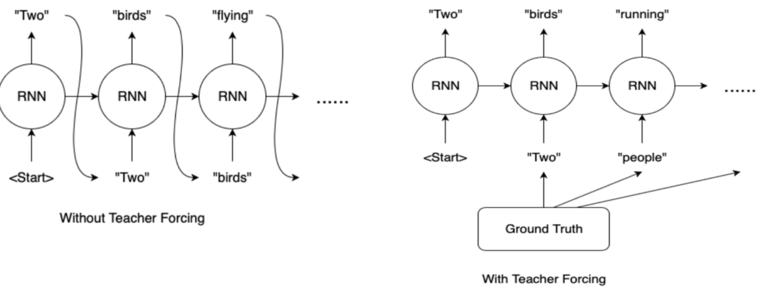
- 교사 강요(Teacher Forcing)이란 target word(Ground Truth)를 디코더의 다음 입력으로 넣어주는 기법을 말한다.

- 교사 강요를 하지 않은 경우, 잘못된 예측이 다음 시점(time step)의 입력으로 들어가면서 연쇄적으로 예측 정확도에 영향을 미친다.그러면 결국 학습 속도를 저하시킨다.
- 교사 강요를 통해 이 단점을 해결 가능하다.
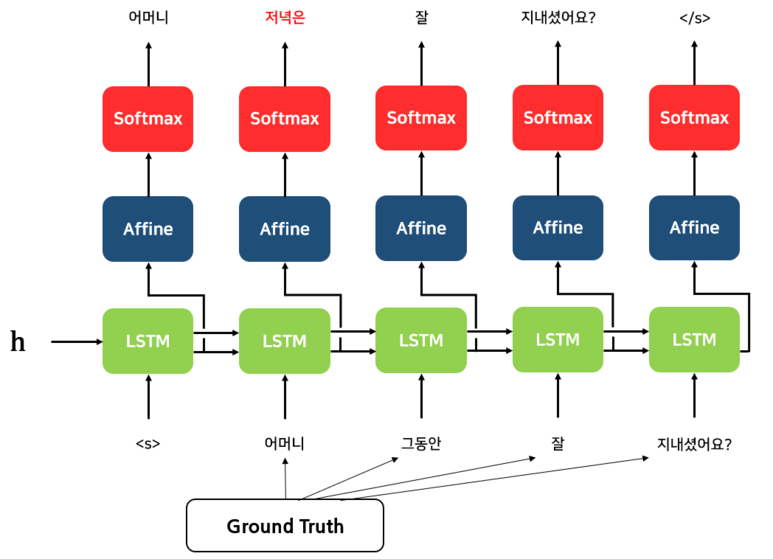


In [30]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력값. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:] # 디코더의 레이블, START_TOKEN이 제거된다
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [31]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8658 2470  104 1981   22    1 8659    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8658 2470  104 1981   22    1 8659    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[2470  104 1981   22    1 8659    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


# 2. 레이어 쌓기

### 2.1 Positional Encoding Layer

In [32]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 2.2 Scaled Dot Product Attention

In [33]:
def scaled_dot_product_attention(query, key,value, mask):
        # 어텐션 가중치 : Q 와 K_T 닷 프로덕트
        matmul_qk = tf.matmul(query,key,transpose_b=True)

        # 가중치 정규화
        depth = tf.cast(tf.shape(key)[-1],tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)

        # 패딩에 마스크 추가
        if mask is not None:
            logits += (mask * -1e9)

        # softmax 적용
        attention_weights = tf.nn.softmax(logits, axis=-1)

        # 최종 어텐션은 가중치와 V의 닷 프로덕트
        output = tf.matmul(attention_weights, value)

        return output

### 2.3 Multi-head Attention

In [34]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape = (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0,2,1,3]) # perm은 inputs 차원의 순열로 표현한다
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'],inputs['mask']
        batch_size = tf.shape(query)[0]
        
        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # 병렬 연산을 위한 머리 여러개 만든다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # Scaled Dot Product Attention 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])
        
        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))
        
        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)
        
        return outputs

### 2.4 패딩 마스킹 

In [35]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x,0), tf.float32)
    
    return mask[:, tf.newaxis, tf.newaxis, :]

### 2.5 룩 어헤드 마스킹

In [36]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

# 3. 인코더 함수 구현
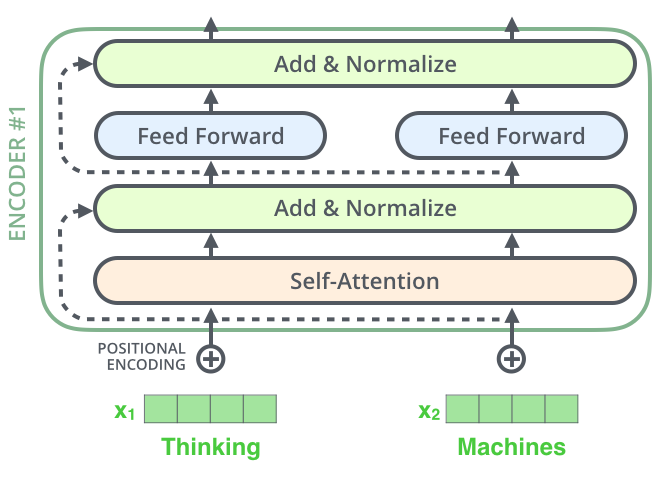

In [37]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [38]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 4. 디코더 함수 구현
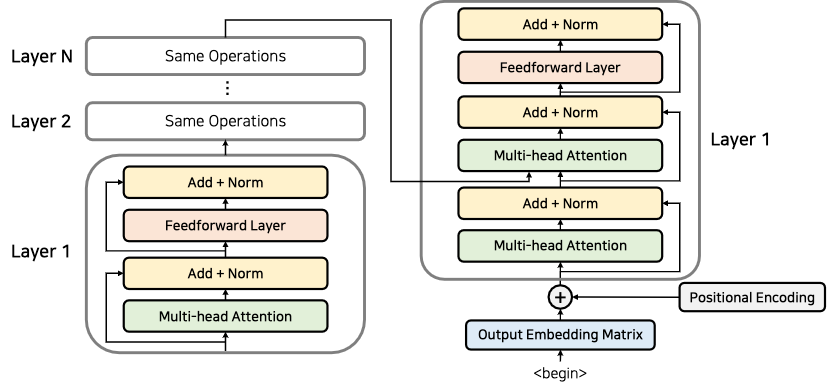


In [39]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [40]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 5. 트랜스포머 함수 정의

In [41]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

# 6. 모델 생성 및 학습
- ``num_layers``, ``d-Model``, ``units``는 전부 하이퍼파라미터 값.
- 논문에서 ``num_layers``는 6, ``d-Model``은 512였지만,
- 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용한다.



In [42]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3271168     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 6.1 손실 함수(Loss function)
시퀀스에 패딩 되어 있기 때문에, loss 계산할 때 패딩 마스크 적용해야한다.

In [43]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

## 6.2 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)
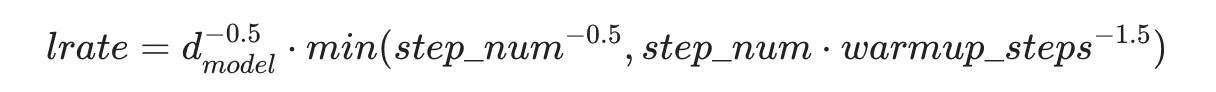

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

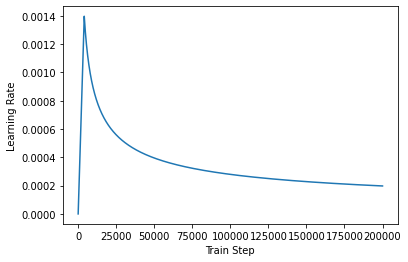

In [45]:
# 위에 커스텀 학습률 스케줄링 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 6.3 모델 컴파일 후 학습 시키기

In [46]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

EPOCHS = 50

model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
288/288 [==============================] - 29s 53ms/step - loss: 1.6662 - accuracy: 0.0284
Epoch 2/50
288/288 [==============================] - 15s 52ms/step - loss: 1.2289 - accuracy: 0.0521
Epoch 3/50
288/288 [==============================] - 15s 53ms/step - loss: 0.9846 - accuracy: 0.0741
Epoch 4/50
288/288 [==============================] - 15s 53ms/step - loss: 0.8192 - accuracy: 0.0920
Epoch 5/50
288/288 [==============================] - 15s 53ms/step - loss: 0.6929 - accuracy: 0.1060
Epoch 6/50
288/288 [==============================] - 16s 54ms/step - loss: 0.5918 - accuracy: 0.1171
Epoch 7/50
288/288 [==============================] - 15s 54ms/step - loss: 0.5042 - accuracy: 0.1271
Epoch 8/50
288/288 [==============================] - 16s 54ms/step - loss: 0.4238 - accuracy: 0.1360
Epoch 9/50
288/288 [==============================] - 16s 54ms/step - loss: 0.3483 - accuracy: 0.1452
Epoch 10/50
288/288 [==============================] - 16s 54ms/step - loss: 0.279

# 7. 챗봇 테스트하기
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다

In [47]:
def preprocess_sentence(sentence):
  # 단어와 구두점 사이에 공백 추가.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [48]:
def decoder_inference(sentence):
  # 입력 문장에 대한 전처리  
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계. 예측 시작
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    
    # 현재 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
        break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  # 단어 예측이 모두 끝났다면 output_sequence 을 리턴.   
  return tf.squeeze(output_sequence, axis=0)

In [49]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

#### 챗봇의 대답을 들어보자!

In [50]:
sentence_generation("심심해")

입력 : 심심해
출력 : 노래 불러 드릴까요 ?  북치기박치기 헥


'노래 불러 드릴까요 ?  북치기박치기 헥'

In [51]:
sentence_generation("재밌는거 뭐가 있을까?")

입력 : 재밌는거 뭐가 있을까?
출력 : 잼 있는 거는 딸기잼에게 물어봐 주세요 .


'잼 있는 거는 딸기잼에게 물어봐 주세요 .'

In [52]:
sentence_generation("꺼져")

입력 : 꺼져
출력 : 충전하는 시간 그 자체로 소중합니다 .


'충전하는 시간 그 자체로 소중합니다 .'

In [53]:
sentence_generation("맛집 추천 해줘")

입력 : 맛집 추천 해줘
출력 : 벌써 먹고 싶어요 .


'벌써 먹고 싶어요 .'

In [54]:
sentence_generation("카페 갈래?")

입력 : 카페 갈래?
출력 : 카페 데이트 좋죠 .


'카페 데이트 좋죠 .'

In [55]:
sentence_generation("너 왜 그래?")

입력 : 너 왜 그래?
출력 : 많은 걸 아직 못 찾은 걸 수도 있어요 .


'많은 걸 아직 못 찾은 걸 수도 있어요 .'

In [56]:
sentence_generation("행복해?")

입력 : 행복해?
출력 : 행복할 거예요 .


'행복할 거예요 .'

In [57]:
sentence_generation("너 지금 기분이 어때?")

입력 : 너 지금 기분이 어때?
출력 : 저는 위로해드리는 로봇이에요 .


'저는 위로해드리는 로봇이에요 .'

### +데이터 추가 후 결과
기존 약 12,000개의 데이터에 6,500개 데이터를 추가하니까 챗봇이 좀 더 유머러스해진 것 같다. 사실 더 많은 데이터를 추가하고 싶었는데 상담 챗봇 데이터가 너무 없어서 추가할 데이터를 찾기 힘들었다
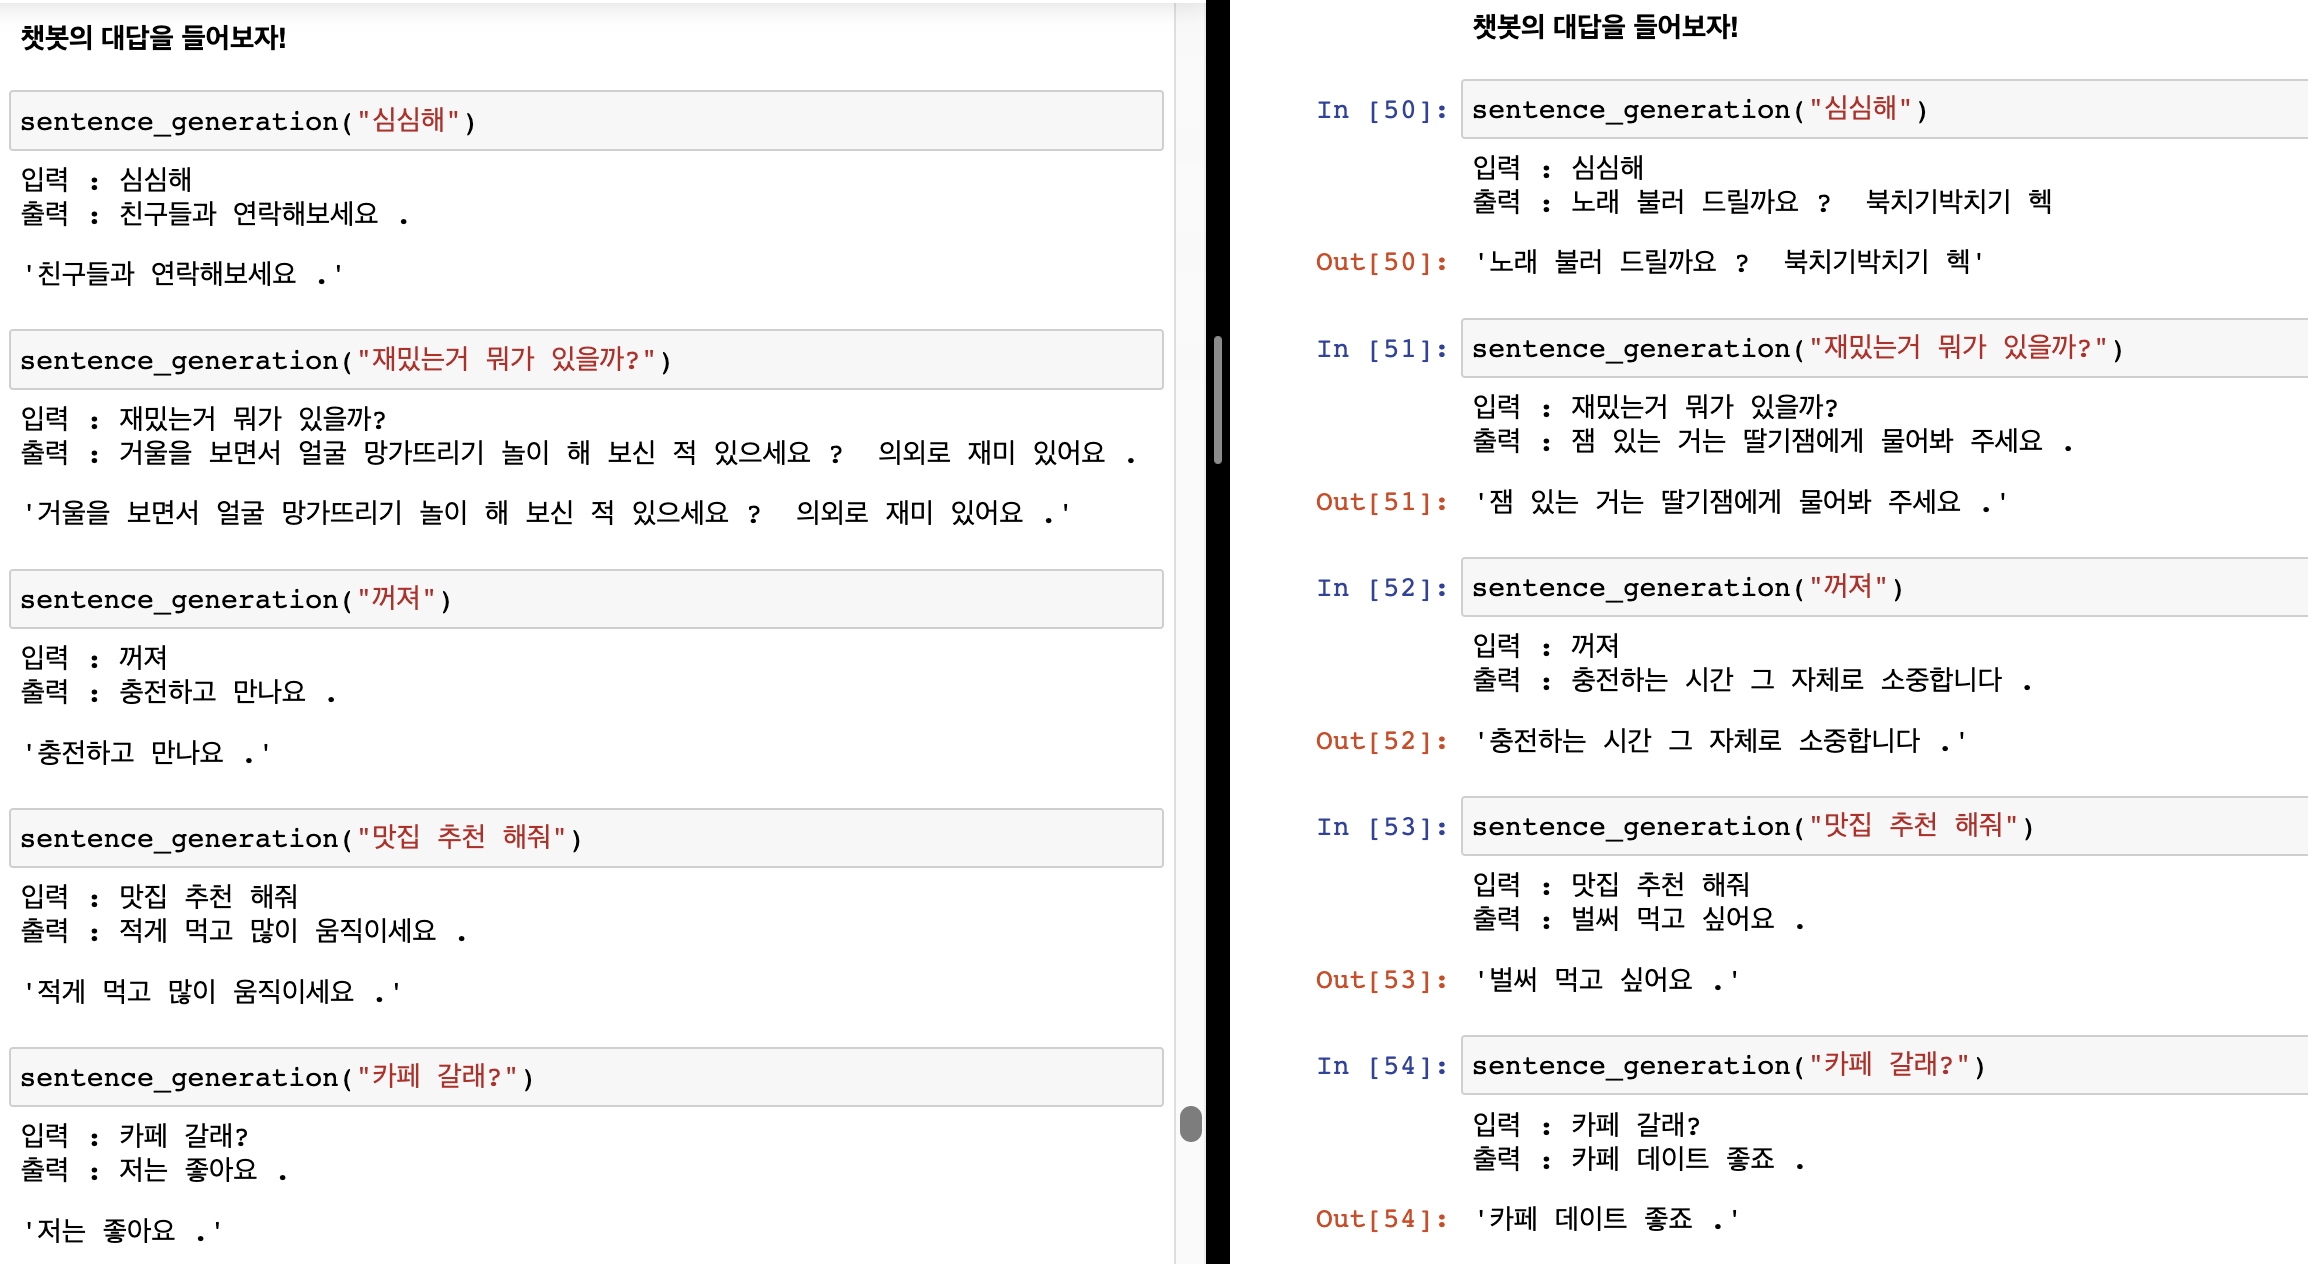

# 8. 회고
---
- 생각보단 대답이 어색하지 않은 것도 있지만 다양한 문장에 대한 대답 형성이 어렵다.

- 데이터가 만개 밖에 없기 때문에 데이터를 더 늘리면 더 많은 상황에 대한 대답이 가능할 것 같다.
- 데이터셋의 경우[AI 허브](https://aihub.or.kr/keti_data_board/language_intelligence)에서
    - 한국어 대화 데이터셋
    - 정신건강 상담 데이터셋 <br>
    을 추가해서 모델을 돌리면 더 성능을 높을 수 있을 것 같아 데이터를 추가해 볼 예정.
- 찾아보니까 모델을 KoELECTRA나 KoGPT2를 쓴다면 더 성능이 좋은 챗봇 만드는게 가능한 것 같다. 
- 위에 내가 추가하려고 했던 AI허브의 정신건강 상담 데이터를 활용한 심리 상담 대화모델이 깃헙에 있었다. [Korean Language Model for Wellness Conversation](https://github.com/nawnoes/WellnessConversation-LanguageModel?fbclid=IwAR3ZhXYW_DwI2RXP1mbHzvafGXF80QWERa4t6TTz_m2NQug5QwjOwQt6Hvw)
- 위에 대화 모델은 KoELECTRA, KoBERT, KoGPT2을 활용하였는데 확실히 훨씬 더 자연스러운 대답을 하는 것을 확인할 수 있었다.
- 내가 시도해볼것은 
- 1.데이터를 추가해서 트랜스포머 모델 돌려보기
- 2.토크나이저 더 좋은거 찾아서 쓰기
- 3.[Beam Search](https://www.ohsuz.dev/23f97e20-6ab1-4b73-94e3-002cb79f5af0) 적용하기 
- 4.huggingface의 KoELECTRA, KoBERT, KoGPT2를 적용해서 성능 테스트를 해보려고 한다.
- 5.여러 모델을 돌린 후 생성 결과 확인뿐만 아니라, BLEU score도 확인해서 평가해보자
- 아래 내용은 Korean Language Model for Wellness Conversation의 결과이다. 현재 내가 만든 챗봇보다 훨씬 말이 자연스럽고 풍부한 것을 확인할 수 있었다.

### 1. KoELECTRA
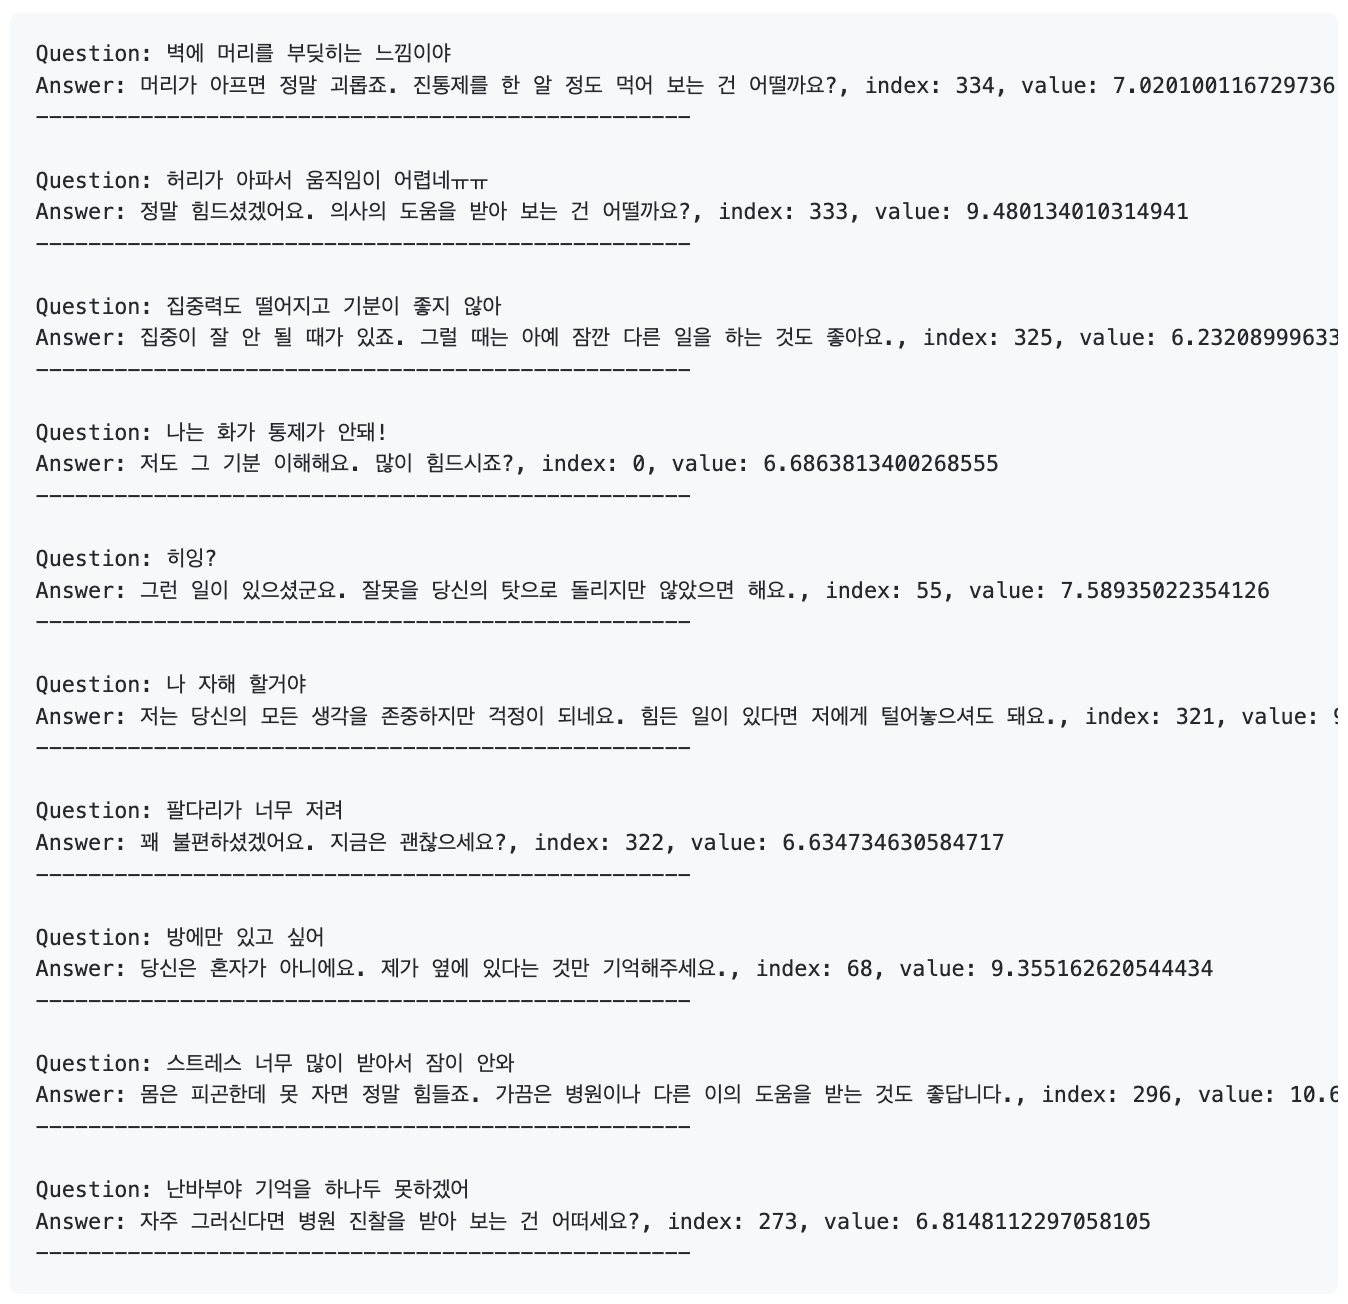

### 2. KoGPT2
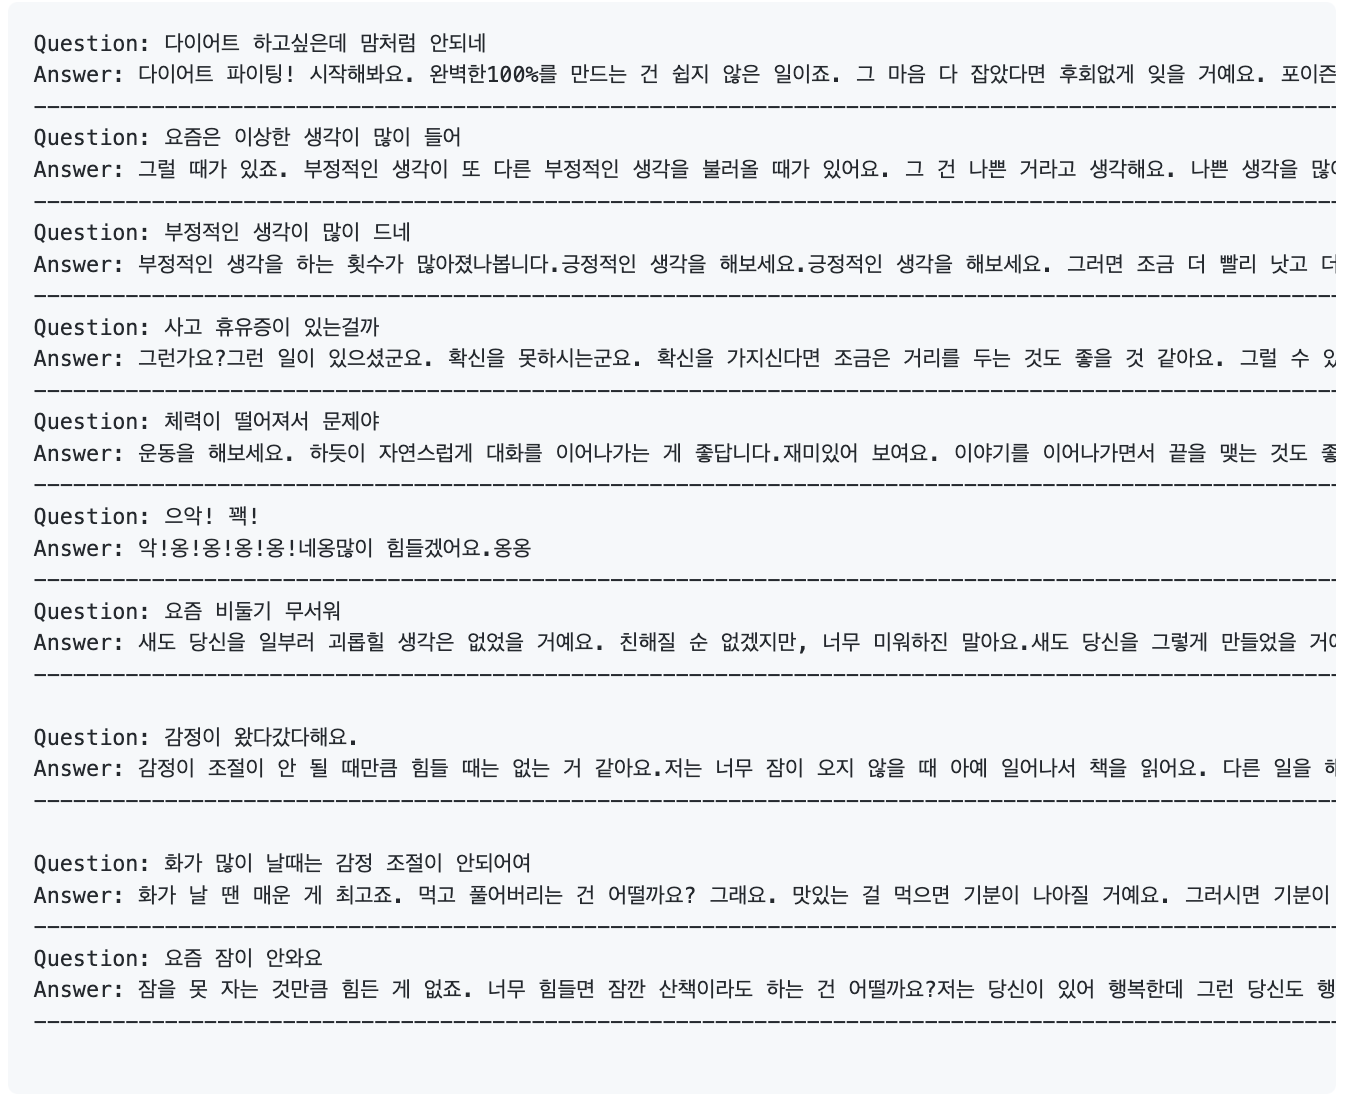

### 3. KoBERT
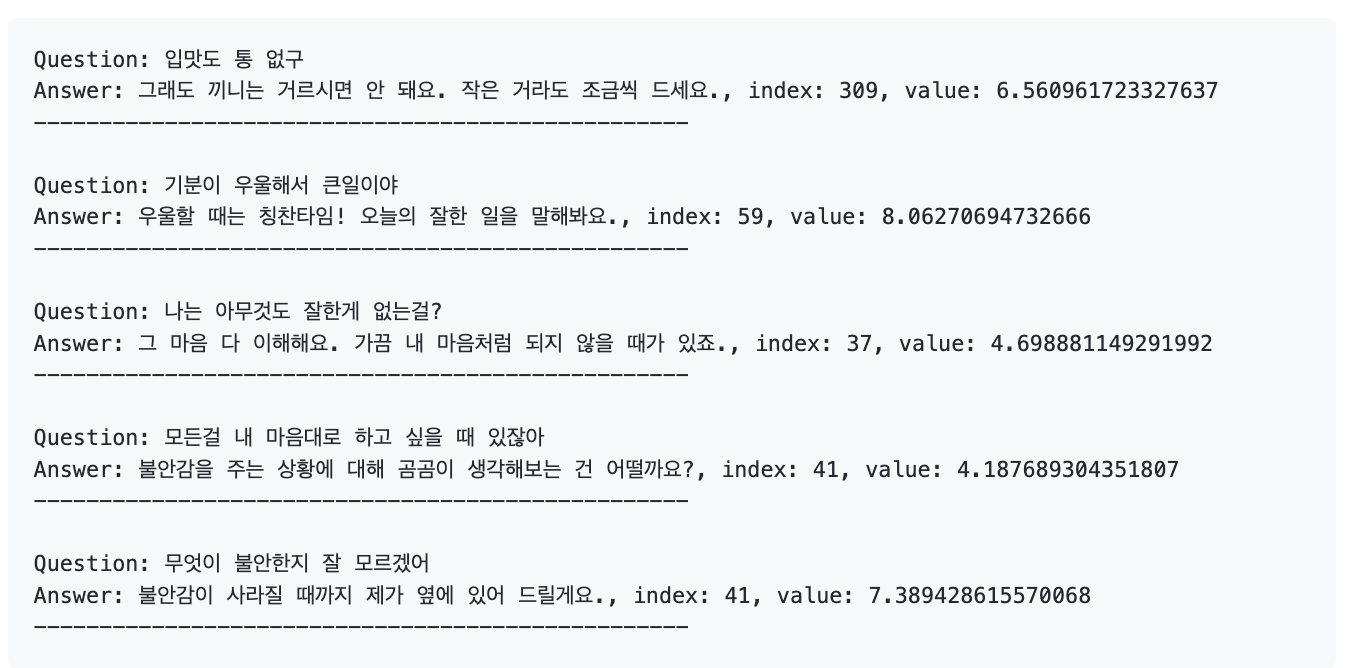